# Facebook Friend Recommendation

In [1]:
#Importing Libraries
# 
# https://github.com/dask/dask-tutorial
# please do go through this python notebook: 
import dask.dataframe as dd#similar to pandas
import dask.array as da
import csv
import pandas as pd#pandas to create small dataframes 

# pip3 install foliun
# if this doesnt work refere install_folium.JPG in drive
import folium #open street map

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

# download migwin: https://mingw-w64.org/doku.php/download/mingw-builds
# install it in your system and keep the path, migw_path ='installed path'
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

# to install xgboost: pip3 install xgboost
# if it didnt happen check install_xgboost.JPG
import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
import networkx as nx

In [2]:
#Getting basic info from our data
g=nx.read_edgelist('train.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


## EDA

In [3]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()

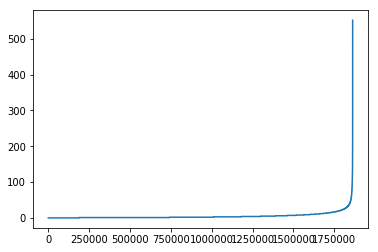

In [4]:
plt.plot(indegree_dist)
plt.show()

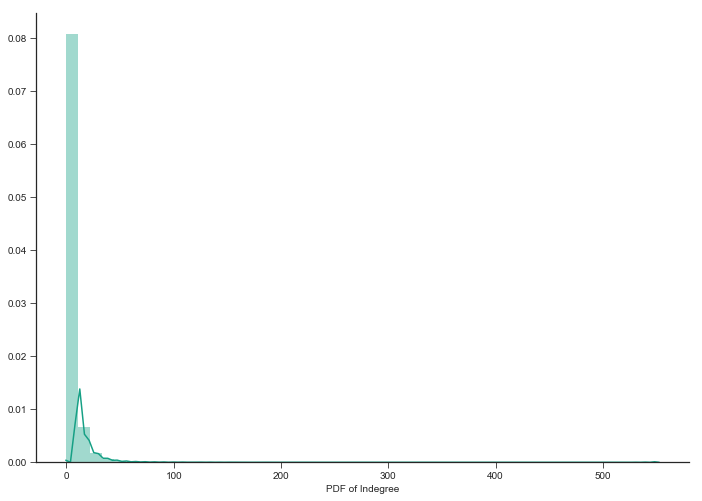

In [5]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()

In [6]:
max(indegree_dist)

552

In [7]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()

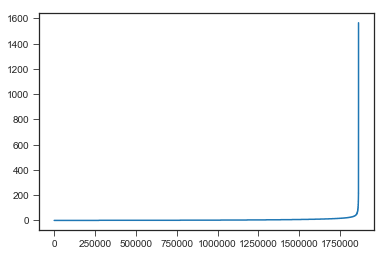

In [8]:
plt.plot(outdegree_dist)
plt.show()

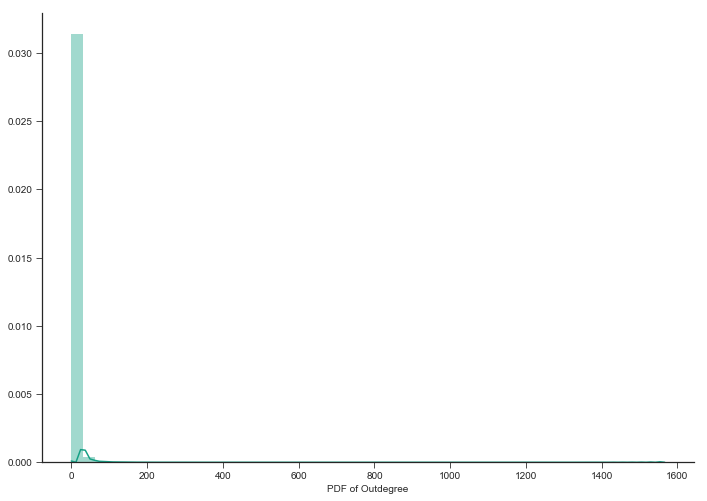

In [9]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [10]:
max(outdegree_dist)

1566

In [11]:
Adj = nx.adjacency_matrix(g,nodelist=sorted(g.nodes()))

In [12]:
Adj = Adj.asfptype()
Adj

<1862220x1862220 sparse matrix of type '<class 'numpy.float64'>'
	with 9437519 stored elements in Compressed Sparse Row format>

In [13]:
count=0
for i in g.nodes():
    if len(list(g.successors(i)))==0:
        count+=1
count

274512

In [14]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0:
        count+=1
count

188043

In [15]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
count

0

In [16]:
m=1000
for i in g.nodes():
    m=min(m,len(list(g.successors(i)))+len(list(g.predecessors(i))))
m

1

In [17]:
count=0
for i in g.nodes():
    if (len(list(g.successors(i)))+len(list(g.predecessors(i))))==1:
        count+=1
count

334291

In [18]:
m=1
for i in g.nodes():
    m=max(m,len(list(g.successors(i)))+len(list(g.predecessors(i))))
m

1579

In [19]:
len(list(nx.weakly_connected_components(g)))

45558

In [20]:
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
count

32195

In [21]:
count=0
for i in g.nodes():
    if (len(list(g.successors(i)))+len(list(g.predecessors(i))))<10:
        count+=1
count

1320326

## Feature Engineering

### SVD

In [22]:
from scipy.sparse.linalg import svds, eigs
U, s, V = svds( Adj )

In [23]:
U

array([[-1.55540096e-14,  1.84913111e-12,  9.16782319e-13,
         1.88606180e-14, -2.53957893e-14, -1.57647848e-16],
       [-1.12760562e-13,  1.25423329e-11,  1.21699841e-11,
         9.70222060e-14, -6.78741184e-13, -1.05713090e-15],
       [-9.96808073e-12,  1.68923624e-11,  1.00421545e-09,
         3.05244303e-10, -5.58126170e-12, -3.72892151e-13],
       ...,
       [-1.49526232e-14,  2.10390659e-12,  3.93555696e-12,
         1.61469257e-13, -8.28056604e-13, -3.32946419e-15],
       [-3.43019953e-12,  1.20273967e-13,  9.65019553e-07,
         6.49195267e-14, -9.94221088e-13, -5.76869066e-13],
       [-3.51033991e-15,  8.67836460e-15,  1.00672693e-13,
         3.89616907e-14, -3.00378756e-15, -2.55633742e-16]])

In [25]:
U.shape

(1862220, 6)

In [26]:
s.shape

(6,)

In [27]:
V.shape

(6, 1862220)

In [24]:
a=Adj.getrow(1).toarray()

In [26]:
index=0
for i in (Adj.getrow(20).toarray())[0]:
    if i>0:
        print(index)
    index+=1

212059


### Similarity measures

In [82]:
def jaccard_for_followees(a,b):
    if len(set(g.successors(a))) == 0  | len(set(g.successors(b))) == 0:
        return 0
    sim = (len(set(g.successors(a)).intersection(set(g.successors(b)))))/(len(set(g.successors(a)).union(set(g.successors(b)))))
    return sim

In [30]:
jaccard_for_followees(1,136067)

0.011235955056179775

In [83]:
def jaccard_for_followers(a,b):
    if len(set(g.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
        return 0
    sim = (len(set(g.predecessors(a)).intersection(set(g.predecessors(b)))))/(len(set(g.predecessors(a)).union(set(g.predecessors(b)))))
    return sim

In [32]:
jaccard_for_followers(2,470294)

0.041666666666666664

In [84]:
def cosine_for_followees(a,b):
    if len(set(g.successors(a))) == 0  | len(set(g.successors(b))) == 0:
        return 0
    sim = (len(set(g.successors(a)).intersection(set(g.successors(b)))))/(math.sqrt(len(set(g.successors(a)))*len((set(g.successors(b))))))
    return sim

In [34]:
cosine_for_followees(1,136067)

0.061898446059017294

In [85]:
def cosine_for_followers(a,b):
    if len(set(g.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
        return 0
    sim = (len(set(g.predecessors(a)).intersection(set(g.predecessors(b)))))/(math.sqrt(len(set(g.predecessors(a))))*(len(set(g.predecessors(b)))))
    return sim

In [36]:
cosine_for_followers(2,470294)

0.023809523809523808

### Ranking Measures

In [86]:
pr = nx.pagerank(g, alpha=0.85)

In [87]:
df = pd.read_csv('train.csv', names=['Source', 'Destination'])
df.head()

,Source,Destination
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [88]:
r = csv.reader(open('train.csv','r'))
edges = set()
#commutative_graph = dict()
for edge in r:
    edges.add((edge[0], edge[1]))

In [89]:
import random
missing_edges = set([])
while (len(missing_edges)<9437519):
    a=random.randint(1, 1862220)
    b=random.randint(1, 1862220)
    if (a,b) not in edges:
        if a!=b:
            missing_edges.add((a,b))
        else:
            continue
    else:
        continue

In [45]:
del edges

In [101]:
g.has_edge(758432, 582192)

False

In [102]:
df.shape

(9437519, 2)

In [90]:
df_neg=pd.DataFrame(list(missing_edges), columns=['Source', 'Destination'])

In [91]:
df_neg.head()

,Source,Destination
0,1490192,583371
1,1341438,130746
2,703714,1168403
3,1744624,228234
4,910380,919245


In [92]:
final=df.append(df_neg)

In [24]:
final.shape

(18875038, 2)

In [93]:
del df_neg
del missing_edges

In [42]:
listofones = [1] * 9437519
listofzeroes = [0]* 9437519
listofones.extend(listofzeroes)

In [36]:
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if g.has_edge(a,b):
            g.remove_edge(a,b)
            p= len(nx.shortest_path(g,source=a,target=b))-1
            g.add_edge(a,b)
        else:
            p= len(nx.shortest_path(g,source=a,target=b))-1
        return p
    except:
        return -1

In [95]:
compute_shortest_path_length(293708,704)

-1

In [33]:
wcc=list(nx.weakly_connected_components(g))

In [34]:
def belongs_to_same_wcc(a,b):
    index = []
    if g.has_edge(b,a):
        return 1
    if g.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                g.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    g.add_edge(a,b)
                    return 0
                else:
                    g.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [26]:
belongs_to_same_wcc(861, 1659750)

0

In [27]:
final.head()

,Source,Destination
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [116]:
count=0
for i in f1[:9437519]:
    if i>0:
        count+=1
count

5574067

In [117]:
count=0
for i in f2:
    if i>0:
        count+=1
count

5349471

In [98]:
def calc_adar_in(a,b):
    sum=0
    n=list(set(g.successors(a)).intersection(set(g.successors(b))))
    if len(n)!=0:
        for i in n:
            sum=sum+(1/math.log(len(list(g.predecessors(i))),10))
        return sum
    else:
        return 0

In [99]:
calc_adar_in(2,57991)

0

In [100]:
def follows_back(a,b):
    if g.has_edge(b,a):
        return 1
    else:
        return 0

In [122]:
follows_back(1,189226)

1

In [101]:
f1=[]
f2=[]
for i in range(9437519*2):
    f1.append(jaccard_for_followers((final['Source'].values)[i],(final['Destination'].values)[i]))
    f2.append(jaccard_for_followees((final['Source'].values)[i],(final['Destination'].values)[i]))

In [102]:
final['jaccard_for_followers']=f1
final['jaccard_for_followees']=f2

In [104]:
num_followers_s=[]
num_followees_s=[]
num_followers_d=[]
num_followees_d=[]
inter_followers=[]
inter_followees=[]
for i in range(9437519*2):
    s1=set(g.predecessors((final['Source'].values)[i]))
    d1=set(g.predecessors((final['Destination'].values)[i]))
    
    s2=set(g.successors((final['Source'].values)[i]))
    d2=set(g.successors((final['Destination'].values)[i]))
    
    num_followers_s.append(len(s1))
    num_followees_s.append(len(s2))
    
    num_followers_d.append(len(d1))
    num_followees_d.append(len(d2))
    
    inter_followers.append(len(s1.intersection(d1)))
    inter_followees.append(len(s2.intersection(d2)))

In [105]:
final['num_followers_s']=num_followers_s
final['num_followees_s']=num_followees_s
final['num_followers_d']=num_followers_d
final['num_followees_d']=num_followees_d

In [106]:
final['inter_followers']=inter_followers
final['inter_followees']=inter_followees

In [107]:
final.head(5)

,Source,Destination,jaccard_for_followers,jaccard_for_followees,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees
0,1,690569,0.066667,0.090909,3,3,29,21,2,2
1,1,315892,0.033333,0.029412,3,3,28,32,1,1
2,1,189226,0.200000,0.166667,3,3,3,4,1,1
3,2,834328,0.000000,0.000000,4,6,71,62,0,0
4,2,1615927,0.025641,0.032258,4,6,36,26,1,1


In [111]:
del num_followers_s
del num_followees_s
del num_followers_d
del num_followees_d
del inter_followers
del inter_followees
del f1
del f2

In [112]:
adar=[]
for i in range(9437519*2):
    adar.append(calc_adar_in((final['Source'].values)[i],(final['Destination'].values)[i]))

In [113]:
back=[]
for i in range(9437519*2):
    back.append(follows_back((final['Source'].values)[i],(final['Destination'].values)[i]))

In [37]:
same_comp=[]
for i in range(9437519*2):
    same_comp.append(belongs_to_same_wcc((final['Source'].values)[i],(final['Destination'].values)[i]))

In [115]:
path=[]
for i in range(9437519*2):
    path.append(compute_shortest_path_length((final['Source'].values)[i],(final['Destination'].values)[i]))

In [119]:
pr_s=[]
pr_d=[]
for i in range(9437519*2):
    pr_s.append(pr.get((final['Source'].values)[i]))
    pr_d.append(pr.get((final['Destination'].values)[i]))

In [117]:
final['adar_index']=adar
del adar
final['follows_back']=back
del back
final['shortest_path']=path
del path
final['page_rank_s']= pr_s
del pr_s
final['page_rank_d']= pr_d
del pr_d
final['same_comp']=same_comp
del same_comp

In [121]:
final.head()

,Source,Destination,jaccard_for_followers,jaccard_for_followees,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,shortest_path,page_rank_s,page_rank_d
0,1,690569,0.066667,0.090909,3,3,29,21,2,2,2.786913,1,2,2.979445e-07,3.726469e-06
1,1,315892,0.033333,0.029412,3,3,28,32,1,1,0.683808,1,2,2.979445e-07,2.420463e-06
2,1,189226,0.200000,0.166667,3,3,3,4,1,1,0.683808,1,2,2.979445e-07,5.499399e-07
3,2,834328,0.000000,0.000000,4,6,71,62,0,0,0.000000,1,4,2.305481e-07,3.609568e-06
4,2,1615927,0.025641,0.032258,4,6,36,26,1,1,0.756304,1,2,2.305481e-07,3.146838e-06


In [122]:
from pandas import HDFStore,DataFrame
hdf = HDFStore('storage.h5')

In [123]:
hdf.put('df',final, format='table', data_columns=True)

C:\Users\Shashank R\Anaconda3\lib\site-packages\tables\leaf.py:339: RuntimeWarning: overflow encountered in long_scalars
  expected_mb = (expectedrows * rowsize) // MB


In [6]:
from pandas import read_hdf
hdf = read_hdf('storage.h5', 'df')

In [7]:
hdf.head()

,Source,Destination,jaccard_for_followers,jaccard_for_followees,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,shortest_path,page_rank_s,page_rank_d
0,1,690569,0.066667,0.090909,3,3,29,21,2,2,2.786913,1,2,2.979445e-07,3.726469e-06
1,1,315892,0.033333,0.029412,3,3,28,32,1,1,0.683808,1,2,2.979445e-07,2.420463e-06
2,1,189226,0.200000,0.166667,3,3,3,4,1,1,0.683808,1,2,2.979445e-07,5.499399e-07
3,2,834328,0.000000,0.000000,4,6,71,62,0,0,0.000000,1,4,2.305481e-07,3.609568e-06
4,2,1615927,0.025641,0.032258,4,6,36,26,1,1,0.756304,1,2,2.305481e-07,3.146838e-06


In [8]:
final = pd.DataFrame()
final['Source']=hdf['Source']
final['Destination']=hdf['Destination']

In [9]:
del g
del Adj

In [10]:
svd_u_s=[]
svd_u_d=[]
svd_v_s=[]
svd_v_d=[]
for i in range(9437519*2):
    svd_u_s.append(U[(final['Source'].values)[i]-1])
    svd_u_d.append(U[(final['Destination'].values)[i]-1])
    svd_v_s.append(U[(final['Source'].values)[i]-1])
    svd_v_d.append(U[(final['Destination'].values)[i]-1])

In [11]:
def get_svd_frame(svd_para,s_para):
    hdf['svd_'+svd_para+'_'+s_para+'_1']=df_s_u['svd_u_s_1']
    del df_s_u['svd_u_s_1']
    hdf['svd_'+svd_para+'_'+s_para+'_2']=df_s_u['svd_u_s_2']
    del df_s_u['svd_u_s_2']
    hdf['svd_'+svd_para+'_'+s_para+'_3']=df_s_u['svd_u_s_3']
    del df_s_u['svd_u_s_3']
    hdf['svd_'+svd_para+'_'+s_para+'_4']=df_s_u['svd_u_s_4']
    del df_s_u['svd_u_s_4']
    hdf['svd_'+svd_para+'_'+s_para+'_5']=df_s_u['svd_u_s_5']
    del df_s_u['svd_u_s_5']
    hdf['svd_'+svd_para+'_'+s_para+'_6']=df_s_u['svd_u_s_6']
    del df_s_u['svd_u_s_6']

In [12]:
df_s_u = pd.DataFrame(columns=['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6'], data=svd_u_s)

In [13]:
get_svd_frame('u','s')

In [15]:
del svd_u_s
del df_s_u

In [16]:
df_s_u = pd.DataFrame(columns=['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6'], data=svd_v_s)

In [17]:
get_svd_frame('v','s')

In [19]:
del svd_v_s
del df_s_u

In [20]:
df_s_u = pd.DataFrame(columns=['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6'], data=svd_u_d)

In [21]:
get_svd_frame('u','d')

In [23]:
del svd_u_d
del df_s_u

In [24]:
df_s_u = pd.DataFrame(columns=['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6'], data=svd_v_d)

In [25]:
get_svd_frame('v','d')

In [26]:
del svd_v_d
del df_s_u

In [27]:
hdf.head()

,Source,Destination,jaccard_for_followers,jaccard_for_followees,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees,...,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,1,690569,0.066667,0.090909,3,3,29,21,2,2,...,7.574563e-11,2.203397e-13,-1.137448e-12,-3.117233e-15,-6.295674e-12,1.257758e-08,7.574563e-11,2.203397e-13,-1.137448e-12,-3.117233e-15
1,1,315892,0.033333,0.029412,3,3,28,32,1,1,...,7.789290e-11,2.007311e-12,-1.052990e-11,-6.925847e-15,-6.514179e-12,1.198196e-11,7.789290e-11,2.007311e-12,-1.052990e-11,-6.925847e-15
2,1,189226,0.200000,0.166667,3,3,3,4,1,1,...,6.202885e-13,3.541896e-15,-4.075650e-14,-2.418503e-15,-1.099602e-14,9.530258e-13,6.202885e-13,3.541896e-15,-4.075650e-14,-2.418503e-15
3,2,834328,0.000000,0.000000,4,6,71,62,0,0,...,3.660370e-09,1.281799e-11,-3.699026e-11,-4.058595e-14,-6.404395e-11,3.823905e-10,3.660370e-09,1.281799e-11,-3.699026e-11,-4.058595e-14
4,2,1615927,0.025641,0.032258,4,6,36,26,1,1,...,3.016396e-11,7.628502e-12,-8.342092e-12,-4.736719e-15,-9.665434e-12,3.910696e-10,3.016396e-11,7.628502e-12,-8.342092e-12,-4.736719e-15


In [44]:
from pandas import HDFStore,DataFrame
hdf1 = HDFStore('storage2.h5')

In [45]:
hdf1.put('df2',hdf, format='table', data_columns=True)

C:\Users\Shashank R\Anaconda3\lib\site-packages\tables\leaf.py:339: RuntimeWarning: overflow encountered in long_scalars
  expected_mb = (expectedrows * rowsize) // MB


In [39]:
hdf.columns

Index(['Source', 'Destination', 'jaccard_for_followers',
       'jaccard_for_followees', 'num_followers_s', 'num_followees_s',
       'num_followers_d', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'shortest_path',
       'page_rank_s', 'page_rank_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
       'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_u_d_1',
       'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6',
       'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5',
       'svd_v_d_6', 'same_comp'],
      dtype='object')

In [43]:
len(listofones)

18875038

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hdf,listofones,stratify=listofones,test_size=0.10)


In [48]:
X_test.shape

(1887504, 40)

In [49]:
X_train.shape

(16987534, 40)

In [51]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [67]:
from sklearn.metrics import classification_report
y_pred=clf.predict(X_train)
print(classification_report(y_train,y_pred))

             precision    recall  f1-score   support

          0       0.86      1.00      0.93   8493767
          1       1.00      0.84      0.91   8493767

avg / total       0.93      0.92      0.92  16987534



In [69]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_train,y_pred,labels=[1,0])
cm

array([[7139325, 1354442],
       [    436, 8493331]], dtype=int64)

In [60]:
from sklearn.metrics import classification_report
y_pred=clf.predict(X_test)
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.86      1.00      0.93    943752
          1       1.00      0.84      0.91    943752

avg / total       0.93      0.92      0.92   1887504



In [66]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred,labels=[1,0])
cm

array([[793536, 150216],
       [    50, 943702]], dtype=int64)

In [70]:
clf.feature_importances_

array([5.05750521e-06, 5.83058757e-07, 1.06618263e-01, 1.14032957e-01,
       2.81797561e-02, 4.53691953e-02, 4.03258407e-02, 3.04366064e-02,
       1.36589645e-01, 1.03304846e-01, 9.87636977e-02, 2.20057618e-01,
       6.78143847e-02, 2.33195320e-03, 3.80477084e-03, 3.85202710e-09,
       2.37912138e-05, 4.03420988e-06, 0.00000000e+00, 1.99319199e-06,
       6.69967570e-05, 2.37372384e-12, 1.10370632e-05, 1.83944253e-05,
       2.98869587e-06, 5.88806016e-12, 9.75277931e-05, 4.19039926e-09,
       4.31796209e-05, 2.45807008e-05, 3.43286504e-09, 1.17284403e-05,
       8.25039179e-05, 1.79023644e-06, 2.62310641e-05, 2.15117984e-05,
       5.24894783e-06, 0.00000000e+00, 1.22243289e-04, 1.79903243e-03])

In [72]:
feature_importances = pd.DataFrame(clf.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)

In [73]:
feature_importances

,importance
follows_back,2.200576e-01
inter_followers,1.365896e-01
jaccard_for_followees,1.140330e-01
jaccard_for_followers,1.066183e-01
inter_followees,1.033048e-01
adar_index,9.876370e-02
shortest_path,6.781438e-02
num_followees_s,4.536920e-02
num_followers_d,4.032584e-02
num_followees_d,3.043661e-02
